In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from easydict import EasyDict

def create_hparams(hparams_string=None, verbose=False):
    """Create model hyperparameters. Parse nondefault from given string."""

    hparams = EasyDict(
        load_mel_from_disk=False,
        training_files='filelists/kss_audio_text_train_filelist.txt',
        validation_files='filelists/kss_audio_text_val_filelist.txt',
        text_cleaners=['english_cleaners'],

        ################################
        # Audio Parameters             #
        ################################
        max_wav_value=32768.0,
        sampling_rate=22050,
        filter_length=1024,
        hop_length=256,
        win_length=1024,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=8000.0,
        
        ################################
        # Model Parameters             #
        ################################
        n_symbols=256,
        symbols_embedding_dim=256,

        # Encoder parameters
        encoder_kernel_size=5,
        encoder_n_convolutions=3,
        encoder_embedding_dim=256,

        ################################
        # Optimization Hyperparameters #
        ################################
        use_saved_learning_rate=False,
        learning_rate=1e-3,
        weight_decay=1e-6,
        grad_clip_thresh=1.0,
        batch_size=1,
        mask_padding=True  # set model's padded outputs to padded values
    )

    return hparams


In [2]:
import numpy as np
from scipy.io.wavfile import read
import torch
import librosa

def text_to_utf8(text):
    utf = []
    for u in text.encode('utf-8'):
        utf.append(u)
        
    return np.array(utf).astype(int)

def get_mask_from_lengths(lengths):
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1)).bool()
    return mask

def load_wav_to_torch(full_path):
    data, sampling_rate = librosa.core.load(full_path, sr=22050, mono=True)
    data /= max(abs(data))
    data = librosa.effects.trim(data, top_db=40, frame_length=1024, hop_length=256)[0]
    return torch.FloatTensor(data.astype(np.float32)), sampling_rate


def load_filepaths_and_text(filename, split="|"):
    with open(filename, encoding='utf-8') as f:
        filepaths_and_text = [line.strip().split(split) for line in f]
    return filepaths_and_text


def to_gpu(x):
    x = x.contiguous()

    if torch.cuda.is_available():
        x = x.cuda(non_blocking=True)
    return torch.autograd.Variable(x)

def make_pad_mask(lengths, xs=None, length_dim=-1):
    """Make mask tensor containing indices of padded part.

    Args:
        lengths (LongTensor or List): Batch of lengths (B,).
        xs (Tensor, optional): The reference tensor. If set, masks will be the same shape as this tensor.
        length_dim (int, optional): Dimension indicator of the above tensor. See the example.

    Returns:
        Tensor: Mask tensor containing indices of padded part.
                dtype=torch.uint8 in PyTorch 1.2-
                dtype=torch.bool in PyTorch 1.2+ (including 1.2)

    Examples:
        With only lengths.

        >>> lengths = [5, 3, 2]
        >>> make_non_pad_mask(lengths)
        masks = [[0, 0, 0, 0 ,0],
                 [0, 0, 0, 1, 1],
                 [0, 0, 1, 1, 1]]

        With the reference tensor.

        >>> xs = torch.zeros((3, 2, 4))
        >>> make_pad_mask(lengths, xs)
        tensor([[[0, 0, 0, 0],
                 [0, 0, 0, 0]],
                [[0, 0, 0, 1],
                 [0, 0, 0, 1]],
                [[0, 0, 1, 1],
                 [0, 0, 1, 1]]], dtype=torch.uint8)
        >>> xs = torch.zeros((3, 2, 6))
        >>> make_pad_mask(lengths, xs)
        tensor([[[0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1]],
                [[0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1]],
                [[0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1]]], dtype=torch.uint8)

        With the reference tensor and dimension indicator.

        >>> xs = torch.zeros((3, 6, 6))
        >>> make_pad_mask(lengths, xs, 1)
        tensor([[[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1]],
                [[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1]],
                [[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1]]], dtype=torch.uint8)
        >>> make_pad_mask(lengths, xs, 2)
        tensor([[[0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1]],
                [[0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1]],
                [[0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1]]], dtype=torch.uint8)

    """
    if length_dim == 0:
        raise ValueError('length_dim cannot be 0: {}'.format(length_dim))

    if not isinstance(lengths, list):
        lengths = lengths.tolist()
    bs = int(len(lengths))
    if xs is None:
        maxlen = int(max(lengths))
    else:
        maxlen = xs.size(length_dim)

    seq_range = torch.arange(0, maxlen, dtype=torch.int64)
    seq_range_expand = seq_range.unsqueeze(0).expand(bs, maxlen)
    seq_length_expand = seq_range_expand.new(lengths).unsqueeze(-1)
    mask = seq_range_expand >= seq_length_expand

    if xs is not None:
        assert xs.size(0) == bs, (xs.size(0), bs)

        if length_dim < 0:
            length_dim = xs.dim() + length_dim
        # ind = (:, None, ..., None, :, , None, ..., None)
        ind = tuple(slice(None) if i in (0, length_dim) else None
                    for i in range(xs.dim()))
        mask = mask[ind].expand_as(xs).to(xs.device)
    return mask


def make_non_pad_mask(lengths, xs=None, length_dim=-1):
    """Make mask tensor containing indices of non-padded part.

    Args:
        lengths (LongTensor or List): Batch of lengths (B,).
        xs (Tensor, optional): The reference tensor. If set, masks will be the same shape as this tensor.
        length_dim (int, optional): Dimension indicator of the above tensor. See the example.

    Returns:
        ByteTensor: mask tensor containing indices of padded part.
                    dtype=torch.uint8 in PyTorch 1.2-
                    dtype=torch.bool in PyTorch 1.2+ (including 1.2)

    Examples:
        With only lengths.

        >>> lengths = [5, 3, 2]
        >>> make_non_pad_mask(lengths)
        masks = [[1, 1, 1, 1 ,1],
                 [1, 1, 1, 0, 0],
                 [1, 1, 0, 0, 0]]

        With the reference tensor.

        >>> xs = torch.zeros((3, 2, 4))
        >>> make_non_pad_mask(lengths, xs)
        tensor([[[1, 1, 1, 1],
                 [1, 1, 1, 1]],
                [[1, 1, 1, 0],
                 [1, 1, 1, 0]],
                [[1, 1, 0, 0],
                 [1, 1, 0, 0]]], dtype=torch.uint8)
        >>> xs = torch.zeros((3, 2, 6))
        >>> make_non_pad_mask(lengths, xs)
        tensor([[[1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0]],
                [[1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0]],
                [[1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0]]], dtype=torch.uint8)

        With the reference tensor and dimension indicator.

        >>> xs = torch.zeros((3, 6, 6))
        >>> make_non_pad_mask(lengths, xs, 1)
        tensor([[[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0]],
                [[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0]],
                [[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0]]], dtype=torch.uint8)
        >>> make_non_pad_mask(lengths, xs, 2)
        tensor([[[1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0]],
                [[1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0]],
                [[1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0]]], dtype=torch.uint8)

    """
    return ~make_pad_mask(lengths, xs, length_dim)


In [3]:
import torch
from librosa.filters import mel as librosa_mel_fn
from audio_processing import dynamic_range_compression
from audio_processing import dynamic_range_decompression
from stft import STFT

class LinearNorm(torch.nn.Module):
    def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
        super(LinearNorm, self).__init__()
        self.linear_layer = torch.nn.Linear(in_dim, out_dim, bias=bias)

        torch.nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, x):
        return self.linear_layer(x)


class ConvNorm(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear'):
        super(ConvNorm, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)

        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal


class TacotronSTFT(torch.nn.Module):
    def __init__(self, filter_length=1024, hop_length=256, win_length=1024,
                 n_mel_channels=80, sampling_rate=22050, mel_fmin=0.0,
                 mel_fmax=8000.0):
        super(TacotronSTFT, self).__init__()
        self.n_mel_channels = n_mel_channels
        self.sampling_rate = sampling_rate
        self.stft_fn = STFT(filter_length, hop_length, win_length)
        mel_basis = librosa_mel_fn(
            sampling_rate, filter_length, n_mel_channels, mel_fmin, mel_fmax)
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer('mel_basis', mel_basis)

    def spectral_normalize(self, magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output

    def spectral_de_normalize(self, magnitudes):
        output = dynamic_range_decompression(magnitudes)
        return output

    def mel_spectrogram(self, y):
        """Computes mel-spectrograms from a batch of waves
        PARAMS
        ------
        y: Variable(torch.FloatTensor) with shape (B, T) in range [-1, 1]

        RETURNS
        -------
        mel_output: torch.FloatTensor of shape (B, n_mel_channels, T)
        """
        assert(torch.min(y.data) >= -1)
        assert(torch.max(y.data) <= 1)

        magnitudes, phases = self.stft_fn.transform(y)
        magnitudes = magnitudes.data
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = self.spectral_normalize(mel_output)
        return mel_output


In [4]:
import random
import numpy as np
import torch
import torch.utils.data
import os

from os import listdir
from os.path import isfile, join

class TextMelLoader(torch.utils.data.Dataset):
    """
        1) loads audio,text pairs
        2) normalizes text and converts them to sequences of one-hot vectors
        3) computes mel-spectrograms from audio files.
    """
    def __init__(self, audiopaths_and_text, hparams):
        self.audiopaths_and_text = load_filepaths_and_text(audiopaths_and_text)
        self.text_cleaners = hparams.text_cleaners
        self.max_wav_value = hparams.max_wav_value
        self.sampling_rate = hparams.sampling_rate
        self.load_mel_from_disk = hparams.load_mel_from_disk
        self.stft = TacotronSTFT(
            hparams.filter_length, hparams.hop_length, hparams.win_length,
            hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
            hparams.mel_fmax)
        random.seed(1234)
        
        attention_dir = 'attention'
        attention_files = [join(attention_dir, f) for f in listdir(attention_dir) if isfile(join(attention_dir, f)) if 'npy' in f]
        
    def get_mel_text_pair(self, audiopath_and_text):
        # separate filename and text
        audiopath, text = audiopath_and_text[0], audiopath_and_text[1]
        text = self.get_text(text)
        mel = self.get_mel(audiopath)
        mel = (mel - np.log(1e-5)) / -np.log(1e-5)
        alignment = self.get_alignment(audiopath)
        
        return (text, mel, alignment, audiopath)
    
    def get_alignment(self, audiopath):
        import ntpath
        from scipy.special import softmax

        basename = ntpath.basename(audiopath)
        alignment = np.load('attention_kss/' + basename + '.npz')
        alignment = alignment['alignment']
        alignment = np.log(np.maximum(alignment, 1e-8))
        alignment = softmax(alignment, axis=0)

        return torch.FloatTensor(alignment)
    
    def get_mel(self, filename):
        if not self.load_mel_from_disk:
            audio, sampling_rate = load_wav_to_torch(filename)
            if sampling_rate != self.stft.sampling_rate:
                raise ValueError("{} {} SR doesn't match target {} SR".format(
                    sampling_rate, self.stft.sampling_rate))
            #audio_norm = audio / self.max_wav_value
            audio_norm = audio
            audio_norm = audio_norm.unsqueeze(0)
            audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
            melspec = self.stft.mel_spectrogram(audio_norm)
            melspec = torch.squeeze(melspec, 0)
        else:
            melspec = torch.from_numpy(np.load(filename))
            assert melspec.size(0) == self.stft.n_mel_channels, (
                'Mel dimension mismatch: given {}, expected {}'.format(
                    melspec.size(0), self.stft.n_mel_channels))
        
        melspec = melspec
        
        return melspec

    def get_text(self, text):
        text_norm = torch.IntTensor(text_to_utf8(text))
        #text_norm = torch.IntTensor(text_to_sequence(text, self.text_cleaners))
        return text_norm

    def __getitem__(self, index):
        return self.get_mel_text_pair(self.audiopaths_and_text[index])

    def __len__(self):
        return len(self.audiopaths_and_text)


class TextMelCollate():
    """ Zero-pads model inputs and targets based on number of frames per setep
    """
    def __init__(self):
        pass

    def __call__(self, batch):
        """Collate's training batch from normalized text and mel-spectrogram
        PARAMS
        ------
        batch: [mel_normalized, text_normalized, alignments, audiopath]
        """
        # Right zero-pad all one-hot text sequences to max input length
        input_lengths, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([len(x[0]) for x in batch]),
            dim=0, descending=True)
        max_input_len = input_lengths[0]

        text_padded = torch.LongTensor(len(batch), max_input_len)
        text_padded.zero_()
        for i in range(len(ids_sorted_decreasing)):
            text = batch[ids_sorted_decreasing[i]][0]
            text_padded[i, :text.size(0)] = text

        # Right zero-pad mel-spec
        num_mels = batch[0][1].size(0)
        max_target_len = max([x[1].size(1) for x in batch])
        max_target_len = 1024

        # include mel padded
        mel_padded = torch.FloatTensor(len(batch), num_mels, max_target_len)
        mel_padded.zero_()
        alignment_padded = torch.FloatTensor(len(batch), max_input_len, max_target_len)
        alignment_padded.zero_()
        output_lengths = torch.LongTensor(len(batch))
        audio_paths = []
        for i in range(len(ids_sorted_decreasing)):
            mel = batch[ids_sorted_decreasing[i]][1]
            mel_padded[i, :, :mel.size(1)] = mel
            output_lengths[i] = mel.size(1)
            
            text = batch[ids_sorted_decreasing[i]][0]
            alignment = batch[ids_sorted_decreasing[i]][2]
            alignment_padded[i, :text.size(0), :mel.size(1)] = alignment
            
            audio_paths.append(batch[ids_sorted_decreasing[i]][3])
        
        outputs = {}
        outputs.update({"text_padded": text_padded})
        outputs.update({"input_lengths": input_lengths})
        outputs.update({"mel_padded": mel_padded})
        outputs.update({"output_lengths": output_lengths})
        outputs.update({"alignment_padded": alignment_padded})
        outputs.update({"audio_paths": audio_paths})
        
        return outputs

In [5]:
from torch.utils.data import DataLoader

hparams = create_hparams()
for param in hparams:
    print(param, ':', hparams[param])
    
def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = None
    collate_fn = TextMelCollate()

    train_sampler = None
    shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=False,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn

train_loader, valset, collate_fn = prepare_dataloaders(hparams)

load_mel_from_disk : False
training_files : filelists/kss_audio_text_train_filelist.txt
validation_files : filelists/kss_audio_text_val_filelist.txt
text_cleaners : ['english_cleaners']
max_wav_value : 32768.0
sampling_rate : 22050
filter_length : 1024
hop_length : 256
win_length : 1024
n_mel_channels : 80
mel_fmin : 0.0
mel_fmax : 8000.0
n_symbols : 256
symbols_embedding_dim : 256
encoder_kernel_size : 5
encoder_n_convolutions : 3
encoder_embedding_dim : 256
use_saved_learning_rate : False
learning_rate : 0.001
weight_decay : 1e-06
grad_clip_thresh : 1.0
batch_size : 1
mask_padding : True


In [6]:
from torch import nn
from torch.nn import functional as F

def squeeze2d(x):
    x1 = x[:, :, ::2, ::2]
    x2 = x[:, :, ::2, 1::2]
    x3 = x[:, :, 1::2, ::2]
    x4 = x[:, :, 1::2, 1::2]
    y = torch.cat([x1, x2, x3, x4], dim=1)
    
    return y

def unsqueeze2d(y):
    
    def sparse_pad(x, row_even=True, column_even=True):
        b, c, h, w = x.size()

        x = x.unsqueeze(4)
        x = F.pad(x, (0, 1) if column_even else (1, 0))
        x = x.reshape(b, c, h, 2*w)
        x = F.pad(x, (0, 2*w) if row_even else (2*w, 0))
        x = x.reshape(b, c, 2*h, 2*w)

        return x

    c = y.size(1) // 4 
    y1 = y[:, :c]
    y1 = sparse_pad(y1)
    y2 = y[:, c:2*c]
    y2 = sparse_pad(y2, column_even=False)
    y3 = y[:, 2*c:3*c]
    y3 = sparse_pad(y3, row_even=False)
    y4 = y[:, 3*c:]
    y4 = sparse_pad(y4, row_even=False, column_even=False)
    x = y1 + y2 + y3 + y4
    
    return x

def split(x):
    c = x.size(1) // 2
    y1 = x[:, :c]
    y2 = x[:, c:]
    
    return y1, y2
    
def merge(y1, y2):
    x = torch.cat([y1, y2], dim=1)
    
    return x

class Permutation2d(nn.Module):
    def __init__(self, c):
        super().__init__()
        
        # Sample a random orthonormal matrix to initialize weights
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        
        # Ensure determinant is 1.0 not -1.0
        if torch.det(W) < 0:
            W[:,0] = -1 * W[:,0]
        #W = torch.eye(c)
        self.W = nn.Parameter(W)
        
    def forward(self, x):
        batch, channel, height, width = x.size()

        #log_det_W = torch.logdet(self.W)
        log_det_W = torch.slogdet(self.W)[1]
        dlog_det = height * width * log_det_W
        y = F.conv2d(x, self.W[:, :, None, None])

        return y, dlog_det
        
    def inverse(self, y):
        W_inverse = self.W.inverse()
        x = F.conv2d(y, W_inverse[:, :, None, None])
        
        return x
    
class ConditionedConv2d(nn.Module):
    def __init__(self, in_channels, cond_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.filter_out = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.filter_cond = nn.Conv2d(in_channels=cond_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        
        self.gate_out = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.gate_cond = nn.Conv2d(in_channels=cond_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        
    def forward(self, x, cond):
        # x: (B, C, H, W)
        # cond: (B, C, H, W)
        
        padded_x = F.pad(x, (2, 0, 1, 1))
        padded_cond = F.pad(cond, (2, 0, 1, 1))
        a = self.filter_out(padded_x)
        b = self.filter_cond(padded_cond)
        c = self.gate_out(padded_x)
        d = self.gate_cond(padded_cond)

        y = F.tanh(a + b) * F.sigmoid(c + d)
        
        return y

class NonLinear2d(nn.Module):
    def __init__(self, c):
        super().__init__()
        h = 256
        self.convs = nn.ModuleList([ConditionedConv2d(in_channels=c, cond_channels=hparams.encoder_embedding_dim, out_channels=h,
                                                     kernel_size=3, stride=1, padding=0),
                                   ConditionedConv2d(in_channels=h, cond_channels=hparams.encoder_embedding_dim, out_channels=h,
                                                     kernel_size=3, stride=1, padding=0)])
        self.post_conv = nn.Conv2d(in_channels=h, out_channels=h, kernel_size=1, stride=1, bias=True)
        self.last_conv = nn.Conv2d(in_channels=h, out_channels=c, kernel_size=1, stride=1, bias=True)
        self.last_conv.weight.data.zero_()
        self.last_conv.bias.data.zero_()
        
    def forward(self, x, cond):
        # x: (B, C, H, W)
        # cond: (B, C, W)
        
        # (B, C, 1, W)
        cond = cond.unsqueeze(2)
        # (B, C, H, W)
        cond = cond.repeat(1, 1, x.size(2), 1)
        
        # (B, C, H, W)
        for i, conv in enumerate(self.convs):
            if i == 0:
                x = conv(x, cond)    
            else:
                x = x + conv(x, cond)
        x = F.relu(self.post_conv(x))
        x = self.last_conv(x)
        
        return x
    
class Flow2d(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.permutation = Permutation2d(4*c)
        self.non_linear = NonLinear2d(2*c)
        
    def forward(self, x, cond):

        # Permutation
        y, log_det_W = self.permutation(x)
        # Split
        y1, y2 = split(y)
        # Transform
        m = self.non_linear(y1, cond)
        y2 = y2 + m
        
        # Merge
        y = merge(y1, y2)
        # Log-Determinant
        log_det = log_det_W
        
        return y, log_det
    
    def inverse(self, y, cond):
        # Split
        x1, x2 = split(y)
        # Inverse-Transform
        m = self.non_linear(x1, cond)
        x2 = x2 - m
        # Merge
        x = merge(x1, x2)
        # Inverse-Permutation
        x = self.permutation.inverse(x)
        
        return x
    
        
class SqueezeAndFlows2d(nn.Module):
    def __init__(self, c, num_flow):
        super().__init__()
        self.flows = nn.ModuleList([Flow2d(c) for _ in range(num_flow)])
        
    def forward(self, x, cond):
        y = squeeze2d(x)
        log_det = None
        for flow in self.flows:
            y, dlog_det = flow(y, cond)
            log_det = dlog_det if log_det is None else log_det + dlog_det
            
        return y, log_det
    
    def inverse(self, y, cond):
        x = y
        for flow in reversed(self.flows):
            x = flow.inverse(x, cond)
        x = unsqueeze2d(x)
        
        return x

In [7]:
class Permutation1d(nn.Module):
    def __init__(self, c):
        super().__init__()
        
        # Sample a random orthonormal matrix to initialize weights
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        
        # Ensure determinant is 1.0 not -1.0
        if torch.det(W) < 0:
            W[:,0] = -1 * W[:,0]
        #W = torch.eye(c)
        self.W = nn.Parameter(W)
        
    def forward(self, x):
        batch, channel, time = x.size()

        log_det_W = torch.slogdet(self.W)[1]
        dlog_det = time * log_det_W
        y = F.conv1d(x, self.W[:, :, None])

        return y, dlog_det
        
    def inverse(self, y):
        W_inverse = self.W.inverse()
        x = F.conv1d(y, W_inverse[:, :, None])
        
        return x

class ConditionedConv1d(nn.Module):
    def __init__(self, in_channels, cond_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.filter_out = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.filter_cond = nn.Conv1d(in_channels=cond_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        
        self.gate_out = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        self.gate_cond = nn.Conv1d(in_channels=cond_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, stride=stride, padding=padding)
        
    def forward(self, x, cond):
        # x: (B, C, T)
        # cond: (B, C, T)
        
        padded_x = F.pad(x, (2, 0))
        padded_cond = F.pad(cond, (2, 0))
        a = self.filter_out(padded_x)
        b = self.filter_cond(padded_cond)
        c = self.gate_out(padded_x)
        d = self.gate_cond(padded_cond)

        y = F.tanh(a + b) * F.sigmoid(c + d)
        
        return y
    
class NonLinear1d(nn.Module):
    def __init__(self, c):
        super().__init__()
        h = 256
        self.convs = nn.ModuleList([ConditionedConv1d(in_channels=c, cond_channels=hparams.encoder_embedding_dim, out_channels=h,
                                                     kernel_size=3, stride=1, padding=0),
                                   ConditionedConv1d(in_channels=h, cond_channels=hparams.encoder_embedding_dim, out_channels=h,
                                                     kernel_size=3, stride=1, padding=0)])
        
        self.post_conv = nn.Conv1d(in_channels=h, out_channels=h, kernel_size=1, stride=1, bias=True)
        self.last_conv = nn.Conv1d(in_channels=h, out_channels=c, kernel_size=1, stride=1, bias=True)
        self.last_conv.weight.data.zero_()
        self.last_conv.bias.data.zero_()
        
    def forward(self, x, cond):
        # x: (B, C, T)
        # cond: (B, C, T)
        
        # (B, C, T)
        for i, conv in enumerate(self.convs):
            if i == 0:
                x = conv(x, cond)
            else:
                x = x + conv(x, cond)
        
        x = F.relu(self.post_conv(x))
        x = self.last_conv(x)
        
        return x
    
class Flow1d(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.permutation = Permutation1d(c)
        self.non_linear = NonLinear1d(c//2)
        
    def forward(self, x, cond):

        # Permutation
        y, log_det_W = self.permutation(x)
        # Split
        y1, y2 = split(y)
        # Transform
        m = self.non_linear(y1, cond)
        y2 = y2 + m
        
        # Merge
        y = merge(y1, y2)
        # Log-Determinant
        log_det = log_det_W
        
        return y, log_det
    
    def inverse(self, y, cond):
        # Split
        x1, x2 = split(y)
        # Inverse-Transform
        m = self.non_linear(x1, cond)
        x2 = x2 - m
        # Merge
        x = merge(x1, x2)
        # Inverse-Permutation
        x = self.permutation.inverse(x)
        
        return x
    
class ReshapeAndFlows1d(nn.Module):
    def __init__(self, c, num_flow):
        super().__init__()
        self.flows = nn.ModuleList([Flow1d(c) for _ in range(num_flow)])
        
    def forward(self, x, cond):
        batch, channel, height, width = x.size()        
        y = x.reshape(batch, channel * height, width)
        
        log_det = None
        for flow in self.flows:
            y, dlog_det = flow(y, cond)
            log_det = dlog_det if log_det is None else log_det + dlog_det
        
        y = y.reshape(batch, channel, height, width)
        
        return y, log_det
    
    def inverse(self, y, cond):
        batch, channel, height, width = y.size()        
        x = y.reshape(batch, channel * height, width)
        
        for flow in reversed(self.flows):
            x = flow.inverse(x, cond)
            
        x = x.reshape(batch, channel, height, width)
        
        return x

In [8]:
class Encoder(nn.Module):
    """Encoder module:
        - Three 1-d convolution banks
        - Bidirectional LSTM
    """
    def __init__(self, hparams):
        super(Encoder, self).__init__()

        convolutions = []
        for _ in range(hparams.encoder_n_convolutions):
            conv_layer = nn.Sequential(
                ConvNorm(hparams.encoder_embedding_dim,
                         hparams.encoder_embedding_dim,
                         kernel_size=hparams.encoder_kernel_size, stride=1,
                         padding=int((hparams.encoder_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='relu'))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

        self.lstm = nn.LSTM(hparams.encoder_embedding_dim,
                            int(hparams.encoder_embedding_dim / 2), 1,
                            batch_first=True, bidirectional=True)

    def forward(self, x, input_lengths):
        for conv in self.convolutions:
            x = F.relu(conv(x))

        x = x.transpose(1, 2)

        # pytorch tensor are not reversible, hence the conversion
        input_lengths = input_lengths.cpu().numpy()
        x = nn.utils.rnn.pack_padded_sequence(
            x, input_lengths, batch_first=True)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(
            outputs, batch_first=True)

        return outputs.transpose(1, 2)

    def inference(self, x):
        for conv in self.convolutions:
            x = F.relu(conv(x))

        x = x.transpose(1, 2)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        return outputs.transpose(1, 2)
    
class Pooling(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv1d(hparams.encoder_embedding_dim, hparams.encoder_embedding_dim, 
                                              kernel_size=3, stride=2, padding=1), 
                                    nn.Conv1d(hparams.encoder_embedding_dim, hparams.encoder_embedding_dim, 
                                              kernel_size=3, stride=2, padding=1), 
                                    nn.Conv1d(hparams.encoder_embedding_dim, hparams.encoder_embedding_dim, 
                                              kernel_size=3, stride=2, padding=1),
                                    nn.Conv1d(hparams.encoder_embedding_dim, hparams.encoder_embedding_dim, 
                                              kernel_size=3, stride=2, padding=1)])
        
    def forward(self, x):
        outputs = [x]
        for conv in self.convs:
            x = F.relu(conv(x))
            outputs.append(x)
            
        return outputs

In [9]:
from math import sqrt

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder(hparams)
        self.embedding = nn.Embedding(
            hparams.n_symbols, hparams.symbols_embedding_dim)
        std = sqrt(2.0 / (hparams.n_symbols + hparams.symbols_embedding_dim))
        val = sqrt(3.0) * std  # uniform bounds for std
        self.embedding.weight.data.uniform_(-val, val)
        self.pooling = Pooling(hparams)
        
        depth = 8
        self.squeeze_and_flows_list = nn.ModuleList([ReshapeAndFlows1d(80, depth),#torch.Size([1, 1, 80, 1024])
                                                     SqueezeAndFlows2d(1, depth), #torch.Size([1, 1, 80, 1024])
                                                     ReshapeAndFlows1d(80, depth),#torch.Size([1, 2, 40, 512])
                                                     SqueezeAndFlows2d(1, depth), #torch.Size([1, 1, 40, 512])
                                                     ReshapeAndFlows1d(40, depth),#torch.Size([1, 2, 20, 256])
                                                     SqueezeAndFlows2d(1, depth), #torch.Size([1, 1, 20, 256])
                                                     ReshapeAndFlows1d(20, depth),#torch.Size([1, 2, 10, 128])
                                                     SqueezeAndFlows2d(1, depth), #torch.Size([1, 1, 10, 128])
                                                     ReshapeAndFlows1d(10, depth)])#torch.Size([1, 2, 5, 64])
        
    def forward(self, batch):
        # texts: (B, N)
        # mels: (B, C=1, H=80, W=1024)
        # alignments: (B, N, T)
        
        # (B, C, N)
        embedded_inputs = self.embedding(batch["text_padded"]).transpose(1, 2)
        # (B, C, N)
        encoder_outputs = self.encoder(embedded_inputs, batch["input_lengths"])
        # (B, N, T)
        alignments = batch['alignment_padded']
        # (B, C, T)
        input_contexts = torch.bmm(encoder_outputs, alignments)
        # (B, C, T), (B, C, T//2), (B, C, T//4), (B, C, T//8), (B, C, T//16)
        input_contexts_list = self.pooling(input_contexts)
        
        y = batch['mel_padded']
        zs = []
        log_det = None
        for i, squeeze_and_flows in enumerate(self.squeeze_and_flows_list):
            context_index = 0 if i == 0 else (i + 1) // 2
            y, dlog_det = squeeze_and_flows(y, input_contexts_list[context_index])
            log_det = dlog_det if log_det is None else log_det + dlog_det
            
            if i != 0:
                channel = y.size(1) // 2
                zs.append(y[:, channel:])
                y = y[:, :channel]
            
        zs.append(y)
        
        return zs, log_det
    
    def inverse(self, text, alignments, zs):
        
        embedded_inputs = self.embedding(text).transpose(1, 2)
        encoder_outputs = self.encoder.inference(embedded_inputs)
        input_contexts = torch.bmm(encoder_outputs, alignments)
        input_contexts_list = self.pooling(input_contexts)
        
        x = zs[-1]
        i = -2
        context_index = -1
        even = True
        for squeeze_and_flows in reversed(self.squeeze_and_flows_list[1:]):
            x = torch.cat([x, zs[i]], dim=1)
            i = i - 1
            x = squeeze_and_flows.inverse(x, input_contexts_list[context_index])
            if not even:
                context_index = context_index - 1
            even = not even
            
        x = self.squeeze_and_flows_list[0].inverse(x, input_contexts_list[0])
            
        return x
    
    def loss(self, zs, log_det):
        
        lls = None
        dim = 0
        for z in zs:
            dim += z.size(1) * z.size(2) * z.size(3)
            ll = torch.sum(-0.5 * (np.log(2 * np.pi) + z ** 2), dim=(1, 2, 3))
            lls = ll if lls is None else lls + ll
        
        log_likelihood = lls + log_det
        loss = torch.mean(-log_likelihood / dim)
        
        return loss

In [10]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/floent_pad-kss'
logger = Logger(save_dir)

!ls $save_dir

events.out.tfevents.1587811011.scpark-X299-WU8
events.out.tfevents.1587811104.scpark-X299-WU8
events.out.tfevents.1587811127.scpark-X299-WU8
events.out.tfevents.1587811232.scpark-X299-WU8
save_0


done


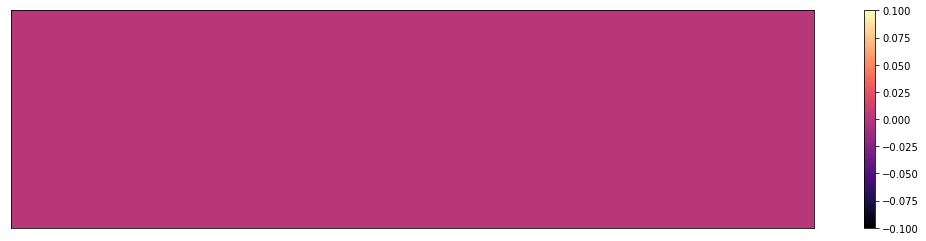

In [11]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import librosa.display
import time
import torch.distributed as dist

def get_save_path(save_dir, step):
    return save_dir + '/' + 'save_' + str(step)

step = 0
GPU = 0

model = Model()
model.cuda(GPU)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

path = get_save_path(save_dir, step)
if os.path.exists(path) and False:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    try:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        optimizer.lr
    except:
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    step = checkpoint['step']
    step += 1
    print('loaded')

print('done')

plt.figure(figsize=[18, 4])
librosa.display.specshow(np.zeros([100, 100]))
plt.colorbar()
plt.show()


In [12]:
def to_gpu(batch):
    batch['text_padded'] = batch['text_padded'].cuda()
    batch['input_lengths'] = batch['input_lengths'].cuda()
    batch['mel_padded'] = batch['mel_padded'].cuda()
    batch['mel_padded'] = batch['mel_padded'].unsqueeze(1)
    batch['output_lengths'] = batch['output_lengths'].cuda()
    batch['alignment_padded'] = batch['alignment_padded'].cuda()
    
    return batch

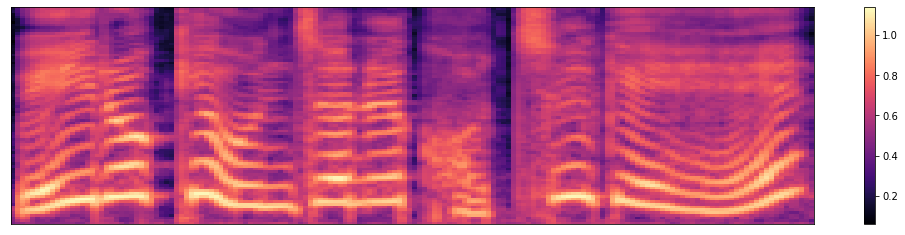

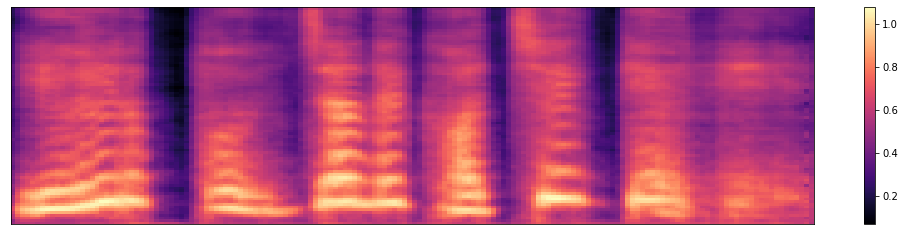

step: 12570 loss: -2.8182990550994873 elapsed time: 1.2849743366241455
step: 12571 loss: -2.977015256881714 elapsed time: 1.258742332458496
step: 12572 loss: -2.879265308380127 elapsed time: 1.2909493446350098
step: 12573 loss: -3.00544810295105 elapsed time: 1.3140530586242676
step: 12574 loss: -3.1434009075164795 elapsed time: 1.271846055984497
step: 12575 loss: -3.0324440002441406 elapsed time: 1.2659742832183838
step: 12576 loss: -2.833312749862671 elapsed time: 1.2636151313781738
step: 12577 loss: -3.0297906398773193 elapsed time: 1.2935905456542969
step: 12578 loss: -3.0922176837921143 elapsed time: 1.2823076248168945
step: 12579 loss: -3.1192352771759033 elapsed time: 1.2647192478179932
step: 12580 loss: -3.1610500812530518 elapsed time: 1.261652946472168
step: 12581 loss: -2.888798236846924 elapsed time: 1.2794067859649658
step: 12582 loss: -2.8286590576171875 elapsed time: 1.2878496646881104
step: 12583 loss: -2.937157154083252 elapsed time: 1.2893152236938477
step: 12584 loss

In [ ]:
import time

while(True):
    for i, batch in enumerate(train_loader):
        t0 = time.time()
        
        batch = to_gpu(batch)
        model.zero_grad()
        z, log_det = model(batch)
        
        loss = model.loss(z, log_det)
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        t1 = time.time()
        print('step:', step, 'loss:', loss.item(), 'elapsed time:', t1 - t0)
        t0 = time.time()

        if step % 10 == 0:
            logger.log('loss', loss.item(), step)

        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = get_save_path(save_dir, step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
        
        if i % 100 == 0:
            clear_output() 
            
            length = batch['output_lengths'].item()
            #length = 1024
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(batch['mel_padded'][0, 0, :, :length].data.cpu().numpy())
            plt.colorbar()
            plt.show()
            
            zs = [torch.randn(1, 2, 40, 512).cuda() * 0.8,
                  torch.randn(1, 1, 40, 512).cuda() * 0.8,
                  torch.randn(1, 2, 20, 256).cuda() * 0.9,
                  torch.randn(1, 1, 20, 256).cuda() * 0.9,

                  torch.randn(1, 2, 10, 128).cuda() * 1.0,
                  torch.randn(1, 1, 10, 128).cuda() * 1.0,
                  torch.randn(1, 2, 5, 64).cuda() * 1.0,
                  torch.randn(1, 1, 5, 64).cuda() * 1.0,
                  torch.randn(1, 1, 5, 64).cuda() * 1.0]

            img_gen = model.inverse(batch['text_padded'][:1], batch['alignment_padded'][:1], zs)
            _img_gen = img_gen.data.cpu().numpy()
            _img_gen = np.clip(_img_gen, 0, 5)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(_img_gen[0, 0, :, :length])
            plt.colorbar()
            plt.show()
        
        step += 1

In [14]:
path = get_save_path(save_dir, step)
torch.save({
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, path)
print('saved', path)


saved save/floent_pad-kss/save_11469


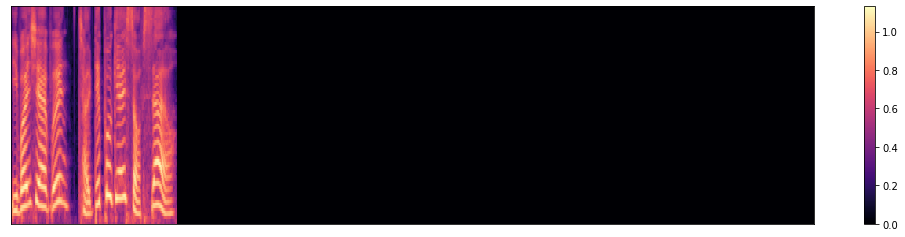

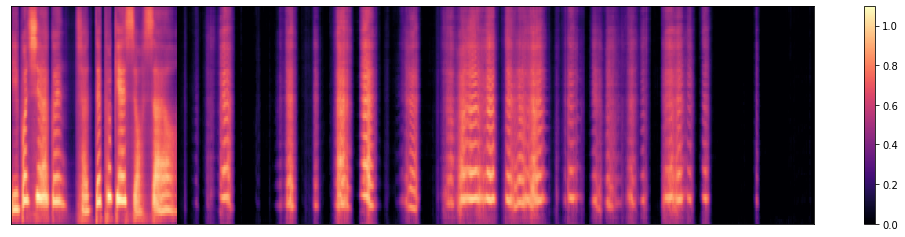

In [15]:
plt.figure(figsize=[18, 4])
librosa.display.specshow(batch['mel_padded'][0, 0].data.cpu().numpy())
plt.colorbar()
plt.show()

zs = [torch.randn(1, 2, 40, 512).cuda() * 0.4,
      torch.randn(1, 1, 40, 512).cuda() * 0.6,
      torch.randn(1, 2, 20, 256).cuda() * 0.6,
      torch.randn(1, 1, 20, 256).cuda() * 0.8,

      torch.randn(1, 2, 10, 128).cuda() * 0.8,
      torch.randn(1, 1, 10, 128).cuda() * 1.0,
      torch.randn(1, 2, 5, 64).cuda() * 1.0,
      torch.randn(1, 1, 5, 64).cuda() * 1.2,
      torch.randn(1, 1, 5, 64).cuda() * 1.2]

img_gen = model.inverse(batch['text_padded'][:1], batch['alignment_padded'][:1], zs)
_img_gen = img_gen.data.cpu().numpy()
_img_gen = np.clip(_img_gen, 0, 5)

plt.figure(figsize=[18, 4])
librosa.display.specshow(_img_gen[0, 0])
plt.colorbar()
plt.show()

In [16]:
batch['output_lengths'].item()

212

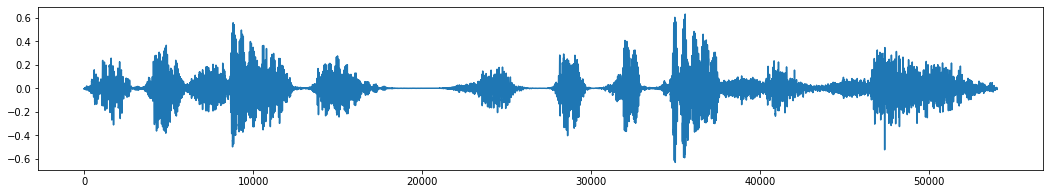

In [17]:
import scipy 

def mel_to_wave(mel):
    # mel : [T, C]
    
    def dynamic_range_decompression(y, lower_bound=1e-5):
        
        log_lower_bound = np.log(lower_bound)
        return np.exp(mel * -log_lower_bound + log_lower_bound)
    
    mel = dynamic_range_decompression(mel)
    mel_basis = librosa.filters.mel(sr=22050, n_fft=1024, 
                                    n_mels=80, fmin=0, fmax=8000)
    inv_basis = np.linalg.pinv(mel_basis)
    spec = inv_basis @ mel
    
    wave = librosa.core.griffinlim(spec, hop_length=hparams.hop_length)
    return wave

wave = mel_to_wave(_img_gen[0, 0, :, :batch['output_lengths'].item()])
plt.figure(figsize=[18, 3])
plt.plot(wave)
plt.show()

import IPython.display as ipd
ipd.Audio(wave, rate=22050)

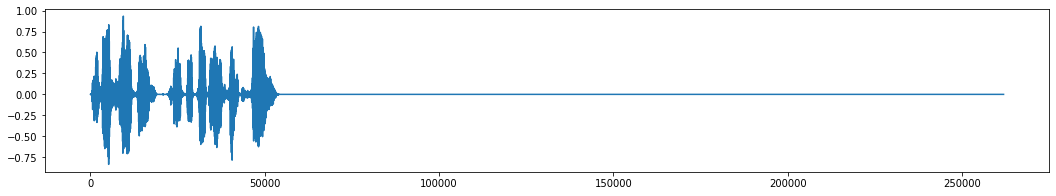

In [18]:
wave = mel_to_wave(batch['mel_padded'][0, 0].data.cpu().numpy())

plt.figure(figsize=[18, 3])
plt.plot(wave)
plt.show()

import IPython.display as ipd
ipd.Audio(wave, rate=22050)